# Load Libraries and Resources

In [1]:
library('readr')
library('blabr')
library('plyr')
library('dplyr')
library('ggplot2')
library('rjson')
library('parallel')
library("readxl")
library('dotwhisker')
library('broom')
library('lme4')
library('irr')
library('tuneR')
library('ggExtra')
library('brms')
library('ggstance')
library('xtable')
library('stringr')
source('PLEARN_analysis_helper.R')
source('texvars.R')
tvc = initialize_texvar_cache()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix

Loading required package: lpSolve

Loading required package: Rcpp

Loading 'brms' package (version 2.17.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following object is masked from ‘package:lme4’:

    ngrps


The following object is masked from ‘package:stats’:

    ar



Attaching package: ‘ggstance’


The following objects are masked from ‘package:ggplot2’:

    geom_errorbarh, GeomErrorbarh




# Load Data Objects

In [2]:
subject_info = readRDS(file='intermediate_data/subject_info.RData')
ed_df = readRDS(file='intermediate_data/eyetracking_fixations_df.RData')

In [3]:
all_scores = readRDS(file='intermediate_data/all_scores.RData')

# Compare Eyetracking Between Experiments

Note that we wait to run this analysis to Notebook 04 so that we can compare high- and low- producing children

In [4]:
ed_df$study = ed_df$expt_version
ed_df$study[ed_df$study == 'agreement'] = 'Study 3'
ed_df$study[ed_df$study == 'redblue'] = 'Study 2'
ed_df$study[ed_df$study == 'scene'] = 'Study 1'
ed_df$study[ed_df$study == 'agreement-lookit'] = 'Study 4'
ed_df$study = factor(ed_df$study, c("Study 1", "Study 2", "Study 3", "Study 4"))

## Adults and Children

[1] "facet clause:"
[1] "~ study"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + target + type + study"


Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message in geom_line(data = agg_means_df, aes_string(x = "Time", y = "cfial_bin", :
“Ignoring unknown parameters: `shape`”


[1] "figures/study!=\"Study4\"_target_~study.pdf"


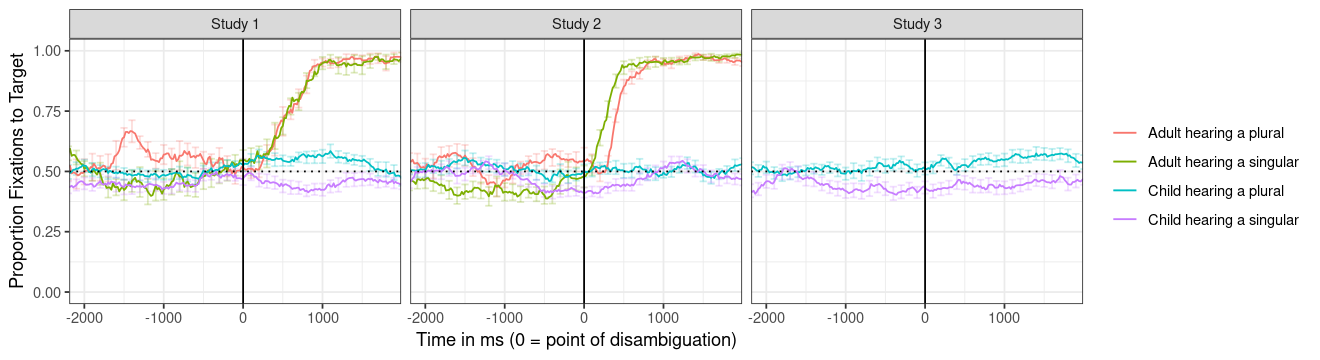

In [5]:
source('PLEARN_analysis_helper.R')
getGroupPlot(ed_df, 
        grouping_var = 'target',
        linetype_var = 'type',
        filter_clause = 'study != "Study 4"', 
        facet_clause = '~ study',
        facet_type = 'wrap',
        loessSpan=.2, 
        x_start = -2000,
        x_end = 1800,
        mean_pp_duration= NULL,
        delay_ms= 367, 
        group_title = NULL,
        save_plot=T,
        plot_size = c(11,3))

## Older Kids

[1] "facet clause:"
[1] "~ study"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + target + type + study"


Warning message in geom_line(data = agg_means_df, aes_string(x = "Time", y = "cfial_bin", :
“Ignoring unknown parameters: `shape`”


[1] "figures/study!=\"Study4\"&type==\"child\"&\nage_in_days>30*30.5_target_~study.pdf"


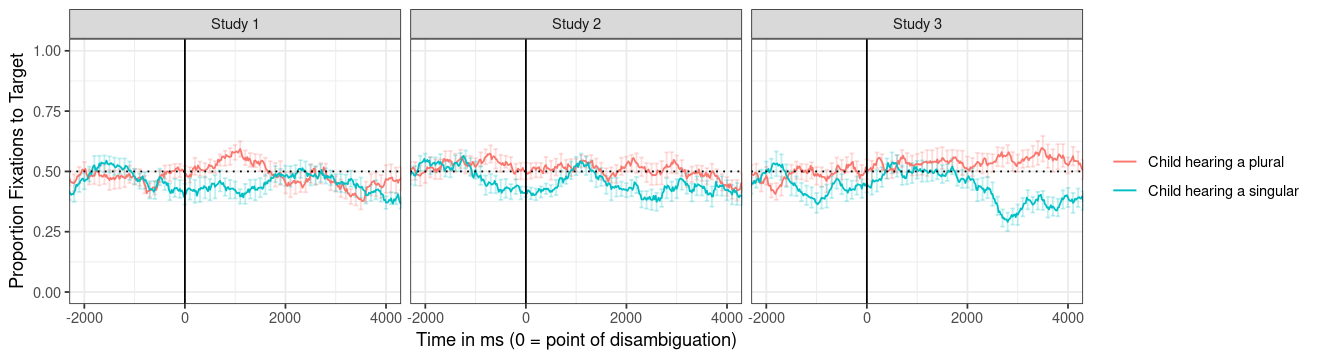

In [6]:
source('PLEARN_analysis_helper.R')
getGroupPlot(ed_df, 
        grouping_var = 'target',
        linetype_var = 'type',
        filter_clause = 'study != "Study 4" & type == "child" &
                   age_in_days > 30 * 30.5',
        facet_clause = '~ study',
        facet_type = 'wrap',
        loessSpan=.2, 
        x_start = -2000,
        x_end = 4000,
        mean_pp_duration= NULL,
        delay_ms= 367,  
        group_title = NULL,
        save_plot=T,
        plot_size = c(11,3))

## High Producers

[1] "facet clause:"
[1] "~ study"
[1] "Final aggregate statement is:"
[1] "cfial_bin ~ Time + target + type + study"


Warning message in geom_line(data = agg_means_df, aes_string(x = "Time", y = "cfial_bin", :
“Ignoring unknown parameters: `shape`”


[1] "figures/study!=\"Study4\"&type==\"child\"&\nbroad_score>.5_target_~study.pdf"


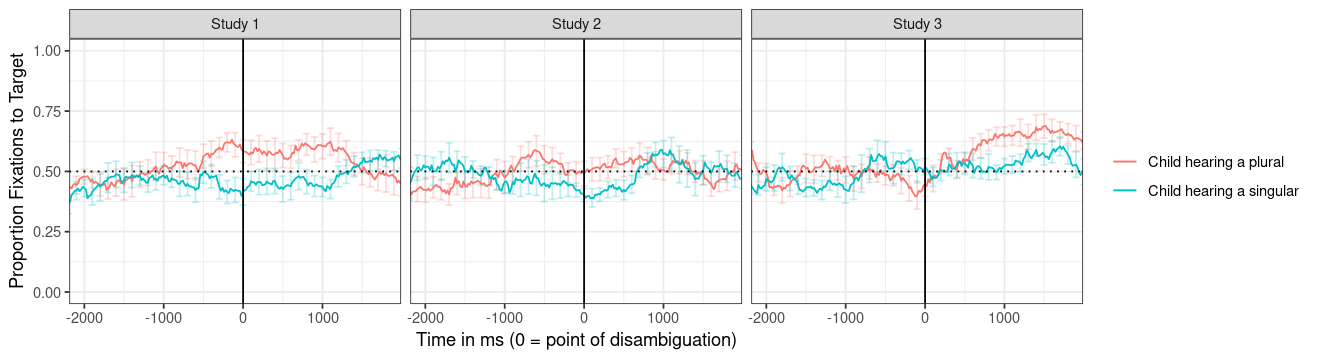

In [7]:
source('PLEARN_analysis_helper.R')
getGroupPlot(ed_df , 
        grouping_var = 'target',
        linetype_var = 'type',
        filter_clause = 'study != "Study 4" & type == "child" &
                   broad_score > .5 ',
        facet_clause = '~ study',
        facet_type = 'wrap',
        loessSpan=.2, 
        x_start = -2000,
        x_end = 1800,
        mean_pp_duration= NULL,
        delay_ms= 367,  
        group_title = NULL,
        save_plot=T,
        plot_size = c(11,3))

# Trial Level Eyetracking Regression

In [8]:
source('PLEARN_analysis_helper.R')
ed_df_include = subset(ed_df, !exclude_trial & include_eyetracking & 
    practice == 'n' & child_in_study) #exclude trials here
by_participant = split(ed_df_include, ed_df_include$filename)
trial_scores = do.call('rbind.fill', lapply(by_participant, function(fixbin_df){
        test_participant_receptive_knowledge(fixbin_df, 
            normalizeMethod="preceding", start_analysis_window=367, end_analysis_window= 1800, return_type = 'ltt')
}))    
trial_scores$expt_index = as.numeric(trial_scores$expt_index)

In [9]:
trial_scores = merge(trial_scores, subject_info[,c('participant_name','age_in_months','broad_score',
'narrow_score','nov_pl','fam_pl')])
trial_scores$age_in_months_c = trial_scores$age_in_months - 30

ERROR: Error in `[.data.frame`(subject_info, , c("participant_name", "age_in_months", : undefined columns selected


## Child Age

In [ ]:
source('PLEARN_analysis_helper.R')
child_age_fe = "is_looking_at_target ~ novelty*voicing*animacystatus*target *
        age_in_months_c + expt_index"
child_age_re = "(novelty*voicing*animacystatus*target
         | participant_name) +(target * age_in_months_c |
        s_form)"
eyetracking_lm_results = run_eyetracking_lm(trial_scores, child_age_fe, child_age_re)

In [ ]:
options(repr.plot.width=12, repr.plot.height=8)
ggplot(as.data.frame(subset(eyetracking_lm_results$fixed_effects, model != "Study 4")) 
    ) + geom_errorbarh(aes(xmin=Q2.5, xmax=Q97.5,y=full_term, color=model), size=1,
        height=0, position=ggstance::position_dodgev(height=1)
    ) + geom_vline(xintercept=0, lty=1
    )+ geom_point(aes(x=Estimate,y=full_term, color=model, shape=model),
        position=ggstance::position_dodgev(height=1), size=3) + theme_bw(base_size=14
    )  + xlab('Coefficient (95% Credible Interval)'
    ) + ylab('')  + scale_color_manual(values=c("#E69F00", "#56B4E9", "#E95670", "#000000" ), name = ""
    ) +  scale_shape_discrete(name = "") + theme(
    legend.key.size = unit(.4, "cm"), 
    legend.background = element_rect(fill="white", linetype="solid", 
                                  colour ="black"),
    legend.position = c(.8,.2),
    legend.title=element_blank()
    ) + geom_hline(yintercept = seq(from=.5, to=1000.5, by=1), linetype = 'dashed'
    ) + guides(color = guide_legend(reverse=TRUE), shape = guide_legend(reverse=TRUE)
    ) + coord_cartesian(xlim = c(-.12, .15))
    

ggsave('figures/brms_eyetracking_lmem.pdf', width=6, height = 6)

### Save Tables for SI for all of the above

In [ ]:
source('PLEARN_analysis_helper.R')
library('stringr')
for (i in c(1:3)){
    prepBRMStable(eyetracking_lm_results$models[[i]], paste0('eyetracking_lm_results_model_',i))
    prepBRMStableRandom(eyetracking_lm_results$models[[i]], paste0('eyetracking_lm_results_model_',i),'participant_name')
    prepBRMStableRandom(eyetracking_lm_results$models[[i]], paste0('eyetracking_lm_results_model_',i),'s_form')
}

## Broad Scores

In [ ]:
source('PLEARN_analysis_helper.R')
child_broad_score_fe = "is_looking_at_target ~ novelty*voicing*animacystatus*target *
         broad_score + expt_index"
child_broad_score_re = "(novelty*voicing*animacystatus*target
         | participant_name) +(target * broad_score |
        s_form)"

eyetracking_lm_broad_results = run_eyetracking_lm(trial_scores, child_broad_score_fe, child_broad_score_re)

In [ ]:
options(repr.plot.width=12, repr.plot.height=8)
ggplot(as.data.frame(subset(eyetracking_lm_broad_results$fixed_effects, model != "Study 4")) 
    ) + geom_errorbarh(aes(xmin=Q2.5, xmax=Q97.5,y=full_term, color=model), size=1,
        height=0, position=ggstance::position_dodgev(height=1)
    ) + geom_vline(xintercept=0, lty=1
    )+ geom_point(aes(x=Estimate,y=full_term, color=model, shape=model),
        position=ggstance::position_dodgev(height=1), size=3) + theme_bw(base_size=14
    )  + xlab('Coefficient (95% Credible Interval)'
    ) + ylab('')  + scale_color_manual(values=c("#E69F00", "#56B4E9", "#E95670", "#000000" ), name = ""
    ) +  scale_shape_discrete(name = "") + theme(
    legend.key.size = unit(.4, "cm"), 
    legend.background = element_rect(fill="white", linetype="solid", 
                                  colour ="black"),
    legend.position = c(.8,.2),
    legend.title=element_blank()
    ) + geom_hline(yintercept = seq(from=.5, to=1000.5, by=1), linetype = 'dashed'
    ) + guides(color = guide_legend(reverse=TRUE), shape = guide_legend(reverse=TRUE)
    )
    

ggsave('figures/brms_eyetracking_broad_lmem.pdf', width=6, height = 6)

In [ ]:
source('PLEARN_analysis_helper.R')
library('stringr')
for (i in c(1:3)){
    prepBRMStable(eyetracking_lm_broad_results$models[[i]], paste0('eyetracking_lm_broad_results_',i))
    prepBRMStableRandom(eyetracking_lm_broad_results$models[[i]], paste0('eyetracking_lm_broad_results_',i),'participant_name')
    prepBRMStableRandom(eyetracking_lm_broad_results$models[[i]], paste0('eyetracking_lm_broad_results_',i),'s_form')
}

# Compare Expressive And Receptive Scores

In [ ]:
child_receptive_scores = subset(all_scores, normalizeMethod == 'preceding' & 
                                contrast_type == '1-way')
#exre = EXpressive and REceptive
exre = merge(subject_info[,c('participant_name','age_in_months','broad_score','narrow_score', 'expt_version')], 
    subset(child_receptive_scores, type =='child')
    , by='participant_name', all =T)
exre$expt_version = exre$expt_version.x
exre$expt_version.y = NULL
exre$expt_version.x = NULL
head(exre)

In [ ]:
print('Kids where receptive score could not be evaluated')
subset(exre, is.na(prop_looks_to_target))$participant_name
#these are mostly ones where the eyetracking data was unusable

In [ ]:
options(repr.plot.width=6, repr.plot.height=4)
ggplot(subset(exre, age_in_months > 20 & age_in_months < 40)) + geom_hline(yintercept=0,  
color = 'red', linetype = 'dashed') + geom_jitter(
aes(x=age_in_months, y=prop_looks_to_target), alpha = 1,
    colour="black", size=2, width = .03, height =.03
)  + theme_classic(
    base_size = 16
) + xlab(
    'Age') + ylab(
    'Increase In Target Looking\n(Eyetracking Task)') 


In [ ]:
exre$age_floor = sapply(exre$age_in_months, floor)

In [ ]:
exre$study = exre$expt_version
exre$study[exre$study == 'agreement'] = 'Study 3'
exre$study[exre$study == 'redblue'] = 'Study 2'
exre$study[exre$study == 'scene'] = 'Study 1'
exre$study[exre$study == 'agreement-lookit'] = 'Study 4'
exre$study = factor(exre$study, c("Study 1", "Study 2", "Study 3", "Study 4"))

In [ ]:
options(repr.plot.width=12, repr.plot.height=4)
mid<-mean(exre$prop_looks_to_target)

p1 = ggplot(subset(exre, age_floor >= 24 & age_floor <= 36 & study != 'Study 4')) + geom_hline(yintercept=0,  
color = 'red', linetype = 'dashed') + geom_jitter(
aes(x=age_in_months, y=broad_score, fill=prop_looks_to_target,
   id=prop_looks_to_target), alpha = 1, 
    size=3, width = 0, height =.05, pch=21, colour="black"
) + scale_fill_gradient2() + theme_classic(
    base_size = 16
) +  xlab(
    'Child Age in Months') + ylab(
    'Proportion Plural Successes\n(Storybook Task)') + facet_wrap(~study) + 
  labs(fill='Proportion Looks\nTo Target')

ggsave('figures/expressive_vs_age.pdf', plot = p1, width=12, height=4)
p1

In [ ]:
tvc = getSpearmanStats(exre, 'broad_score', 'prop_looks_to_target', 'expRec', tvc)
tvc = getSpearmanStats(exre, 'age_in_months', 'broad_score', 'expAge', tvc)
tvc = getSpearmanStats(exre, 'age_in_months', 'prop_looks_to_target', 'recAge', tvc)

In [ ]:
tvc = getPearsonStats(exre, 'broad_score', 'prop_looks_to_target', 'expRec', tvc)

In [ ]:
options(repr.plot.width=10, repr.plot.height=10)
ggplot(subset(exre, age_in_months > 20 & age_in_months < 40))  + geom_jitter(
aes(x=broad_score, y=prop_looks_to_target, fill=age_in_months), alpha = 1,
    colour="black",pch=21, size=3, width = .03, height =.03
) + scale_fill_continuous(type = "viridis", name = "Child Age\n(Months)") + theme_classic(
    base_size = 16
)+  xlab(
    'Proportion Plural Successes\n(Storybook Task)') + ylab(
    'Increase In Target Looking\n(Eyetracking Task)') + coord_cartesian(xlim=c(0,1)
) + geom_smooth(aes(x=broad_score, prop_looks_to_target), method='lm',
    color='red', alpha=.25) + annotate("text", x = .5, y = -.4, label = pearson_eqn(tvc), parse = TRUE,
    size = 5, color = 'red') + annotate("text", x = .5, y = -.45, label = spear_eqn(tvc), parse = TRUE,
    size = 5, color = 'blue')

ggsave('figures/expressive_vs_receptive.pdf', width=9, height=5)

In [ ]:
options(repr.plot.width=10, repr.plot.height=10)
ggplot(subset(exre, age_in_months > 20 & age_in_months < 40))  + geom_label(
aes(x=broad_score, y=prop_looks_to_target, label=participant_name), alpha = 1,
    colour="black",pch=21, size=3, width = .03, height =.03
) + scale_fill_continuous(type = "viridis", name = "Child Age\n(Months)") + theme_classic(
    base_size = 16
)+  xlab(
    'Proportion Plural Successes\n(Storybook Task)') + ylab(
    'Increase In Target Looking\n(Eyetracking Task)') + coord_cartesian(xlim=c(0,1)
) + geom_smooth(aes(x=broad_score, prop_looks_to_target), method='lm',
    color='red', alpha=.25) + annotate("text", x = .5, y = -.4, label = pearson_eqn(tvc), parse = TRUE,
    size = 5, color = 'red') + annotate("text", x = .5, y = -.45, label = spear_eqn(tvc), parse = TRUE,
    size = 5, color = 'blue')

ggsave('figures/expressive_vs_receptive_named.pdf', width=9, height=5)

# Write Out TexVars

In [ ]:
writeout_texvar_cache(tvc, 'texvars/plearn_analysis_04.tex',appendDate=T)